In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = DATA_DIR / "outputs"
IMAGES_DIR = PROJECT_ROOT / "images" / "phase3_outputs"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
IMAGES_DIR.mkdir(parents=True, exist_ok=True)

cleaned_path = DATA_DIR / "cleaned_superstore.csv"
df = pd.read_csv(cleaned_path) 
print("Loaded cleaned data:", df.shape)


Loaded cleaned data: (9994, 22)


In [2]:
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')

df['Profit Margin %'] = np.where(df['Sales'] != 0, (df['Profit'] / df['Sales']) * 100, 0)
df['Profit Margin %'] = df['Profit Margin %'].round(2)

df['Shipping Time (Days)'] = (df['Ship Date'] - df['Order Date']).dt.days

df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce')

print("Derived columns added. Example:")
display(df[['Order Date','Ship Date','Profit Margin %','Shipping Time (Days)']].head(5))



Derived columns added. Example:


,Order Date,Ship Date,Profit Margin %,Shipping Time (Days)
0,2016-11-08,2016-11-11,16.00,3
1,2016-11-08,2016-11-11,30.00,3
2,2016-06-12,2016-06-16,47.00,4
3,2015-10-11,2015-10-18,-40.00,7
4,2015-10-11,2015-10-18,11.25,7


In [3]:
sales_by_region = df.groupby('Region', as_index=False).agg(
    Total_Sales=('Sales','sum'),
    Total_Profit=('Profit','sum'),
    Avg_Profit_Margin=('Profit Margin %','mean'),
    Avg_Shipping_Days=('Shipping Time (Days)','mean')
)

sales_by_category = df.groupby('Category', as_index=False).agg(
    Total_Sales=('Sales','sum'),
    Total_Profit=('Profit','sum'),
    Avg_Profit_Margin=('Profit Margin %','mean')
)

sales_by_region.to_csv(OUTPUT_DIR / "sales_by_region2.csv", index=False)
sales_by_category.to_csv(OUTPUT_DIR / "sales_by_category2.csv", index=False)

print("Saved sales_by_region and sales_by_category to data/outputs")
display(sales_by_region)
display(sales_by_category)


Saved sales_by_region and sales_by_category to data/outputs


,Region,Total_Sales,Total_Profit,Avg_Profit_Margin,Avg_Shipping_Days
0,Central,501239.8908,39706.3625,-10.407314,4.058115
1,East,678781.2400,91522.7800,16.722711,3.908708
2,South,391721.9050,46749.4303,16.351877,3.958025
3,West,725457.8245,108418.4489,21.948667,3.929753


,Category,Total_Sales,Total_Profit,Avg_Profit_Margin
0,Furniture,741999.7953,18451.2728,3.878326
1,Office Supplies,719047.0320,122490.8008,13.803032
2,Technology,836154.0330,145454.9481,15.613812


C:\Users\hsnrh\AppData\Local\Temp\ipykernel_11868\1708423281.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.set_index('Order Date').resample('M')['Sales'].sum().reset_index()


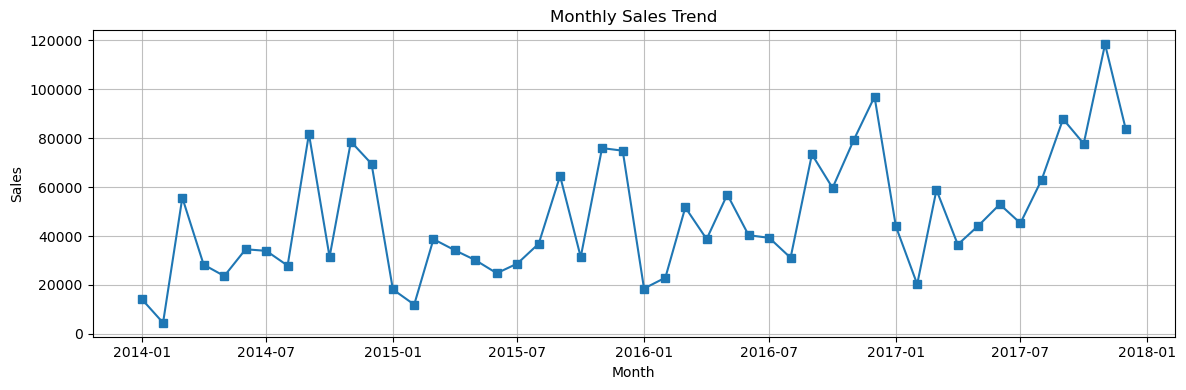

Saved monthly_sales.csv and monthly_sales_trend.png


In [4]:
monthly_sales = df.set_index('Order Date').resample('M')['Sales'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['Order Date'].dt.to_period('M').astype(str)
monthly_sales = monthly_sales[['Month','Sales']]

monthly_sales.to_csv(OUTPUT_DIR / "monthly_sales.csv", index=False)

plt.figure(figsize=(12,4))
plt.plot(pd.to_datetime(monthly_sales['Month']).values, monthly_sales['Sales'].values, marker='s')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.grid(alpha=0.8)
plt.tight_layout()
plt.savefig(IMAGES_DIR / "monthly_sales_trend.png", dpi=150)
plt.show()
print("Saved monthly_sales.csv and monthly_sales_trend.png")


In [5]:
cust_col = None
for c in df.columns:
    if 'customer' in c.lower() and ('id' in c.lower() or 'name' in c.lower()):
        cust_col = c
        break

if cust_col is None:
    cust_col = 'Customer ID' if 'Customer ID' in df.columns else df.columns[0]

top_n_customers = 10
top_customers = df.groupby(cust_col, as_index=False).agg(
    Total_Sales=('Sales','sum'),
    Total_Profit=('Profit','sum'),
    Orders=('Order ID','nunique') if 'Order ID' in df.columns else ('Sales','count')
).sort_values('Total_Sales', ascending=False).head(top_n_customers)

top_customers.to_csv(OUTPUT_DIR / "top_customers.csv", index=False)
top_customers.to_html(OUTPUT_DIR / "top_customers.html", index=False)

html = top_customers.to_html(index=False)
with open(IMAGES_DIR / "top_customers_table.html", "w", encoding="utf-8") as f:
    f.write(html)

print("Saved top_customers.csv and html snapshot")
display(top_customers)


Saved top_customers.csv and html snapshot


,Customer ID,Total_Sales,Total_Profit,Orders
700,SM-20320,25043.050,-1980.7393,5
741,TC-20980,19052.218,8981.3239,5
621,RB-19360,15117.339,6976.0959,6
730,TA-21385,14595.620,4703.7883,4
6,AB-10105,14473.571,5444.8055,10
434,KL-16645,14175.229,806.8550,12
669,SC-20095,14142.334,5757.4119,9
327,HL-15040,12873.298,5622.4292,6
683,SE-20110,12209.438,2650.6769,11
131,CC-12370,12129.072,2177.0493,5


In [6]:
snapshot_date = df['Order Date'].max() + pd.Timedelta(days=1)

# RFM calculation
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days,
    'Order ID': 'nunique' if 'Order ID' in df.columns else 'count',
    'Sales': 'sum'
}).reset_index()

# Rename columns for clarity
rfm.rename(columns={
    'Order Date': 'Recency',
    'Order ID': 'Frequency',
    'Sales': 'Monetary'
}, inplace=True)

rfm['R_rank'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(int)
rfm['F_rank'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['M_rank'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4]).astype(int)

rfm['RFM_Score'] = rfm['R_rank'].astype(str) + rfm['F_rank'].astype(str) + rfm['M_rank'].astype(str)
rfm.to_csv(OUTPUT_DIR / "rfm_customers.csv", index=False)
print("Saved RFM table to data/outputs")
display(rfm.head())

Saved RFM table to data/outputs


,Customer ID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,RFM_Score
0,AA-10315,185,5,5563.560,1,1,4,114
1,AA-10375,20,9,1056.390,4,4,1,441
2,AA-10480,260,4,1790.512,1,1,2,112
3,AA-10645,56,6,5086.935,3,2,4,324
4,AB-10015,416,3,886.156,1,1,1,111


In [7]:
try:
    df.to_parquet(DATA_DIR / "cleaned_superstore.parquet", index=False)
    print("Saved parquet file at:", DATA_DIR / "cleaned_superstore.parquet")
except Exception as e:
    print("Parquet save skipped (pyarrow missing?):", str(e)[:200])

print("\nOutputs in:", OUTPUT_DIR)
for p in OUTPUT_DIR.iterdir():
    print(p.name)


Saved parquet file at: C:\Users\hsnrh\data\cleaned_superstore.parquet

Outputs in: C:\Users\hsnrh\data\outputs
monthly_sales.csv
rfm_customers.csv
sales_by_category.csv
sales_by_category2.csv
sales_by_region.csv
sales_by_region2.csv
top_customers.csv
top_customers.html


In [9]:
df.to_csv(cleaned_path)

In [12]:
df.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Sales per Item,Profit Margin %,Shipping Time (Days)
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,130.9800,16.00,3
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,243.9800,30.00,3
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,7.3100,47.00,4
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,191.5155,-40.00,7
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,11.1840,11.25,7
